In [5]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

# Lecture 19 #

## Review: Constructing a 95 percent confidence interval (known population)
-

In [7]:
sf = Table.read_table('san_francisco_2019.csv')
min_salary = 15 * 20 * 50
sf = sf.where('Salary', are.above(min_salary))
sf.show(6)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,159394,0,57312,216706
Public Protection,Adult Probation,Information Systems,IS Programmer Analyst,70035,0,28671,98706
Public Protection,Adult Probation,Information Systems,IS Project Director,175742,0,60830,236572


**Population Distribution**

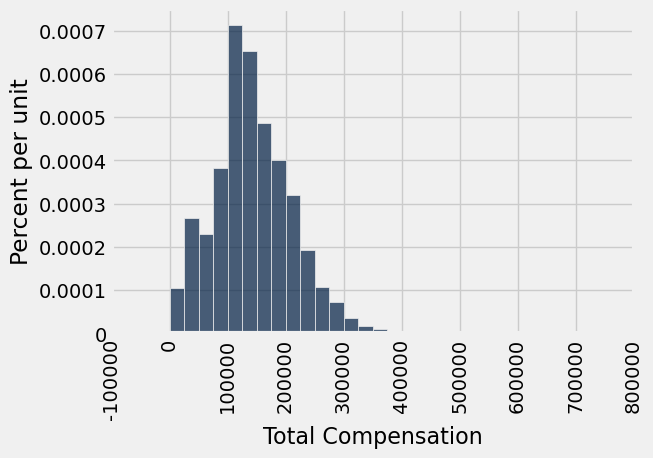

In [9]:
sf_bins = np.arange(0, 726000, 25000)
sf.hist('Total Compensation', bins=sf_bins)

In [11]:
pop_median = percentile(50, sf.column('Total Compensation'))
pop_median

135747.0

**Empirical Distribution**

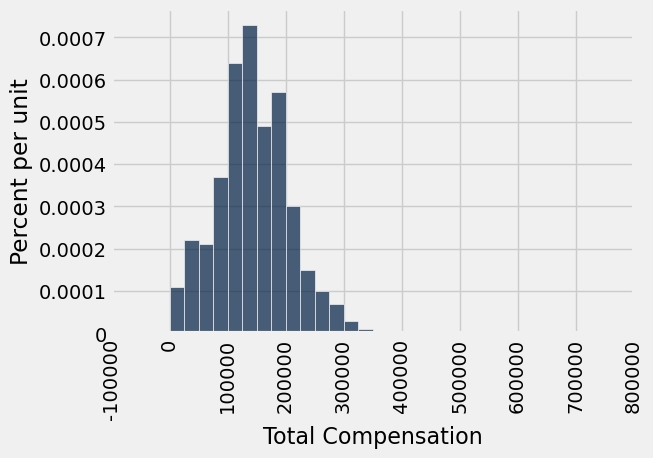

In [13]:
our_sample = sf.sample(400, with_replacement=False)
our_sample.hist('Total Compensation', bins=sf_bins)

In [15]:
percentile(50, our_sample.column('Total Compensation'))

138681.0

In [17]:
def generate_sample_median(samp_size):
    new_sample = sf.sample(samp_size, with_replacement=False)
    return percentile(50, new_sample.column('Total Compensation'))

In [19]:
sample_medians = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(400)
    sample_medians = np.append(sample_medians, new_median)

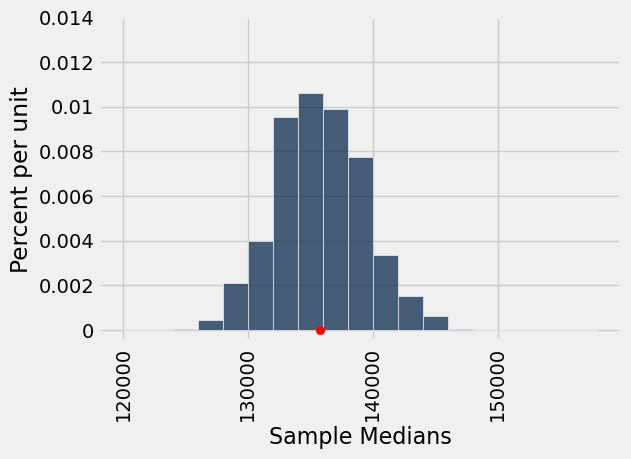

In [20]:
med_bins = np.arange(120000, 160000, 2000)
Table().with_column('Sample Medians', sample_medians).hist(bins=med_bins)

plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

In [23]:
def one_bootstrap_median():
    # draw the bootstrap sample
    resample = our_sample.sample()
    # return the median total compensation in the bootstrap sample
    return percentile(50, resample.column('Total Compensation'))

In [25]:
num_repetitions = 1000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

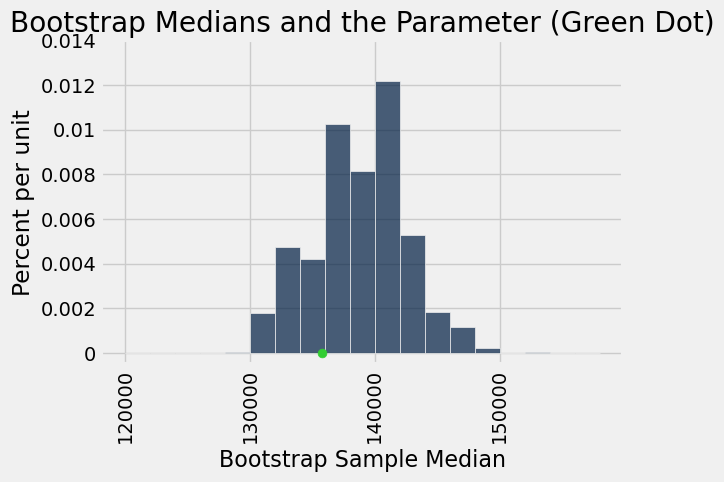

In [27]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(120000, 160000, 2000)
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

In [29]:
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right)

array([ 131828.,  146884.])

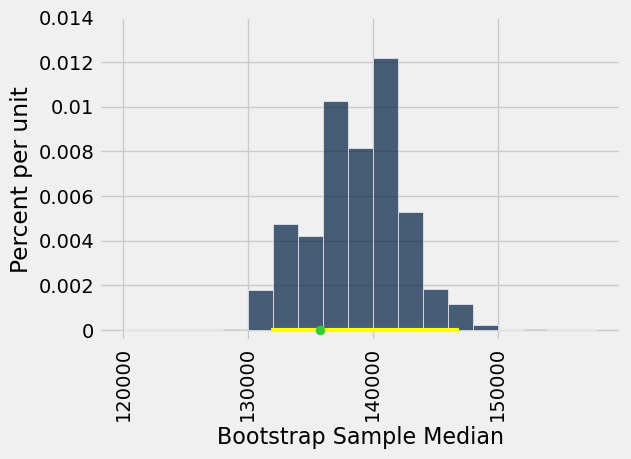

In [31]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);

## Confidence Intervals (unknown population)

In [56]:
births = Table.read_table('baby.csv')
births.show(6)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False


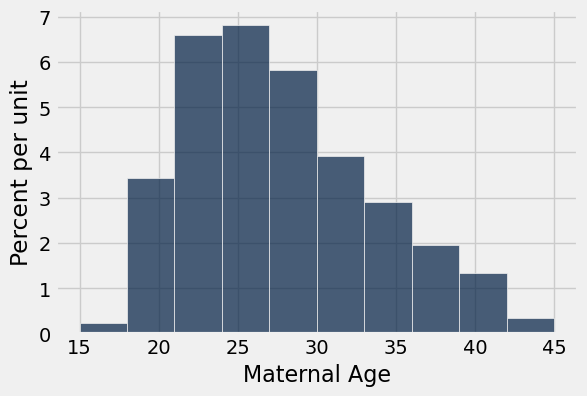

In [62]:
births.hist('Maternal Age')

In [64]:
np.average(births.column('Maternal Age'))

27.228279386712096

### Question
What is the average age of the mothers in the population?

In [50]:
def one_bootstrap_mean():
    resample = births.sample()
    return np.average(resample.column('Maternal Age'))

In [58]:
# Generate means from 3000 bootstrap samples
num_repetitions = 3000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

### Bootstrap Percentile Method for Confidence Interval

The interval of estimates is the "middle 95%" of the bootstrap estimates.

This is called a *95% confidence interval* for the mean age in the population.

In [61]:
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([ 26.89608177,  27.56132879])

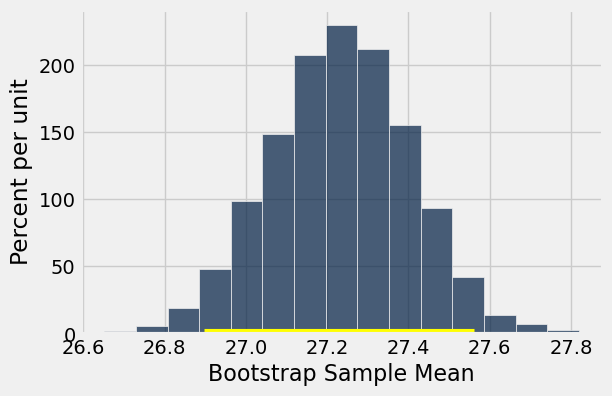

In [63]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);

## More on confidence intervals

In [99]:
# Parameter: Median total compensation in the population
def median_comp(t):
    return percentile(50, t.column('Total Compensation'))

median_comp(sf)

135747.0

In [101]:
def confidence_interval_95(sample_size):
    # Collect one random sample from the population
    our_sample = sf.sample(sample_size, with_replacement=False)
    median_comp(our_sample)

    # Generate the medians of 1000 bootstrap samples
    num_repetitions = 1000
    bstrap_medians = make_array()
    for i in np.arange(num_repetitions):
        # Resample the same number of rows, with replacement
        bstrap_medians = np.append(bstrap_medians, 
                                   median_comp(our_sample.sample()))

    # Find the middle 95% of medians; that's a confidence interval
    left = percentile(2.5, bstrap_medians)
    right = percentile(97.5, bstrap_medians)
    return make_array(left, right)

confidence_interval_95(100)

array([ 118980.,  146750.])

In [103]:
intervals = Table(['k', 'lower', 'upper', 'sample_size'])

for n in [2, 4, 8, 16]:
    for k in np.arange(intervals.num_rows, intervals.num_rows + 20):
        interval = confidence_interval_95(n)
        intervals = intervals.with_row([
            k, interval.item(0), interval.item(1), n
        ])
    
intervals.show(4)

k,lower,upper,sample_size
0,128761,229501,2
1,103637,273803,2
2,100718,191358,2
3,146775,148666,2


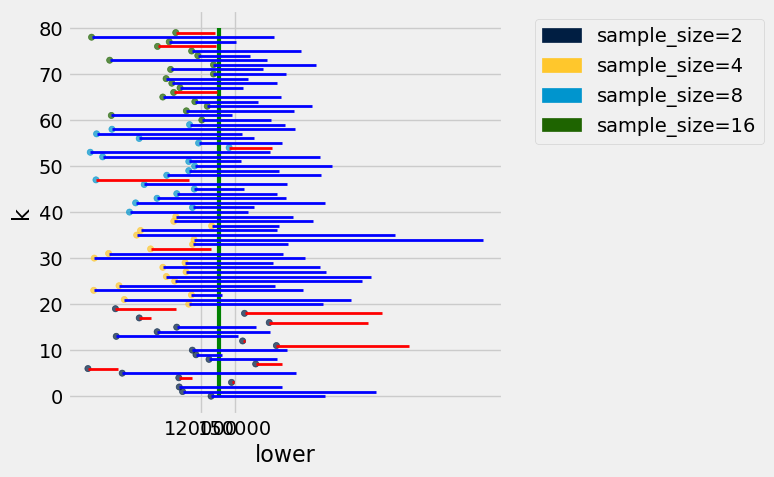

In [105]:
intervals.scatter('lower', 'k', group='sample_size')
truth = median_comp(sf)
plots.plot((truth, truth), (0, intervals.num_rows), color='green', lw=3)
plots.xticks([120000, 150000])
for row in intervals.rows:
    if row.item('lower') > truth or row.item('upper') < truth:
        color = 'red'
    else:
        color = 'blue'
    plots.plot((row.item('lower'), row.item('upper')),
               (row.item('k'), row.item('k')),
               color, lw=2)

## Using the Confidence Interval for Testing Hypotheses

**Null:** The average age of mothers in the population is 25 years; the random sample average is different due to chance.

**Alternative:** The average age of the mothers in the population is not 25 years.

Suppose you use the 5% cutoff for the p-value.

Based on the confidence interval, which hypothesis would you pick?

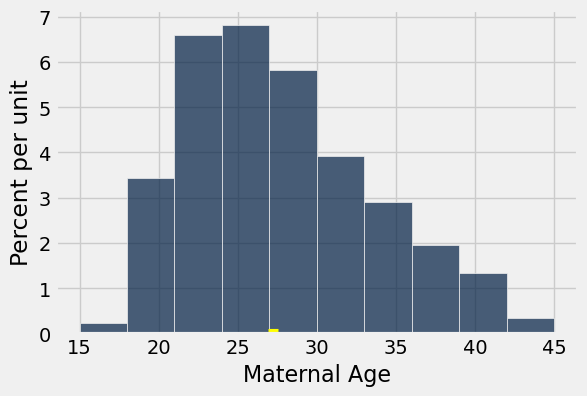

In [96]:
births.hist('Maternal Age')
plots.plot([left, right], [0, 0], color='yellow', lw=8);